# Domain Specific Code Generation using the FormLang DSL

## Abstract

AI and LLM systems are being trained to perform a variety of complex tasks requiring expertise in many software tools, languages and technology stacks. Some of the challenges in this process involve quality data acquisition in large amounts, handling the increase of model parameter count which leads to increasing compute demands and costs, as well as emerging Data Privacy and Intellctual Property concerns related with using 3rd party cloud services for model training.

In this work we attempt to harness and combine the benefits of Abstraction and Determinism provided by Formal Domain Specific Languages (DSLs) with the innate ability of LLMs to learn new languages and their semantics. We propose a novel generation task called "Domain Specific Code Generation" which involve mapping user requests written in natural language to DSL code.

By utilizing a specially crafted DSL called `FormLang` as a case study, we attempt to lay the groundwork for methods of automated DSL dataset generation, training techniques and performance evaluation, with the end goal of creating an AI system capable of generating Web forms according to a user request.

Our `FormLang` DSL allows expressing the semantics of Web-forms using a simplified syntax that does not require much, if any, Web-programming knowledge and expertise.

Given a user prompt in English describing the desired form and its fields the LLM produces syntactically valid `FormLang` output which is run through the accompanying FormLang parser and a hand-crafted React JSX compiler to output a final implementation of the form in JavaScript and React.

The project includes a live demo which demonstrates the capabilities of the system.


## Referring to this work

If you use this work the following quote is preferred:

```bibtex
@misc{guyor2025dscodegenformlang,
      title={Domain Specific Code Generation using the FormLang DSL},
      author={Guy Or},
      year={2025}
}
```

The official repository of this work is hosted in GitHub at https://github.com/guyo13/Form-Lang **TBD** - Make the repo public

## Project Goals

* Define the Task of Domain Specific Code Generation.
* Create an AI training pipeline for FormLang (implemented as a Juypter notebook) which includes:
    * Automatic FormLang Dataset generation using searching algorithms and heuristics.
    * Baseline model selection and loading from Hugging Face.
    * Dataset Preprocessing and loading.
    * Defining performance KPIs for the system.
    * Model fine tuning using Transformers library
    * Model Adapter training using PEFT library.
    * Model upload to Hugging Face Hub and example usage from the Hub.
    *  **(TBD)** Export to ONNX using Optimum and run on-device using Transformers.js.
* Create the “FormLang” language:
    * Describe the problem domain.
    * Defining a viable minimal syntax and semantics which are research focused rather than completeness focused.
    *  **(TBD)** Implementing a “JavaScript React” compile target.
*  **(TBD)** Create a live demo website:
    * **(TBD)** Users input a prompt.
    * **(TBD)** A FormLang editor is populated with the AI’s code generation results.
    * **(TBD)** The form is rendered alongside the generated code.
*  Discuss the project results:
    * Perfornace and user acceptability.
    * **(TBD)** Viability of the implemented methods for the Domain Specific Code Generation task and generalization to other domains.  
    * **(TBD)** Potential enhancements to the system.
    * **(TBD)** Possible research directions on how to learn from user data.


**(TBD)** - Features marked as TBD are depending on the project's progress and timeline constraints as well as proving the viability of the methods and system.

# Notebook Setup

## About the FormLang DSL and its tooling and codebase

The FormLang DSL is implemented using the [Langium](https://langium.org/) project. Langium is a toolkit written in TypeScript that allows language engineers to create DSLs and quickly iterate over their development lifecycle.

Some of the many features offered by Langium are:

* Parser generation - Langium leverages [Chevrotain](https://chevrotain.io/docs/) to create a fast parser that can parse the DSL code to AST.
* TypeScript AST nodes generation - Langium automatically generates TS types that represent the AST of the language.
* Simplified Validation rules - Langium has built in support for writing and executing validation rules with built in error reporting.
* Language Server Protocol support - Langium implements the LSP protocol which allows code completion and syntax highlighting in many IDEs such as VSCode.

Since we are using Langium to parse the FormLang DSL, some of this project tooling and algorithms are written in TypeScript.

To call our TypeScript code from Python we are using two distinct methods:

* [PythonMonkey](https://pythonmonkey.io/) - A Python package that implements FFI between Python and JavaScript.
* Local HTTP API - For some cases in which the PythonMonkey FFI is too slow, we've implemented a local REST-API server that implements some functions we require (e.g for parsing FormLang code to AST).

### Codebase

The entire codebase is hosted in Github at [FormLang](https://github.com/guyo13/Form-Lang).

### Local Setup and Installation instructions - TODO

### Running from Colab

#### Installing PNPM and Bun

In [16]:
!npm install -g pnpm
!npm install -g bun@latest
!npm install -g corepack@latest

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏
changed 1 package in 4s
⠏
⠏1 package is looking for funding
⠏  run `npm fund` for details
⠏⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
changed 5 packages in 26s
⠼⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴
changed 1 package in 2s
⠴

In [17]:
!bun -v

1.2.2


#### Installing PythonMonkey

In [7]:
!pip install pythonmonkey

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.6/288.6 kB 21.0 MB/s eta 0:00:00
  Created wheel for pminit: filename=pminit-1.1.0-cp311-cp311-manylinux_2_35_x86_64.whl size=2127649 sha256=ed91d46baa2c3629c4dc2a35a3fcd3a1bf6feea709ff03298382244ea3bb0fb7
  Stored in directory: /root/.cache/pip/wheels/64/5e/39/2de4476a583c81bbfb9ff2d5dc85aa207866eb1960b06775d7
Successfully built pminit


#### Installing Huggingface Datasets and Evaluate

In [54]:
!pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible

#### Clone the repo

In [22]:
!rm -rf Form-Lang

In [23]:
!git clone -b react_compiler https://github.com/guyo13/Form-Lang.git

Cloning into 'Form-Lang'...
remote: Enumerating objects: 591, done.
remote: Counting objects: 100% (591/591), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 591 (delta 375), reused 569 (delta 357), pack-reused 0 (from 0)
Receiving objects: 100% (591/591), 401.04 KiB | 2.29 MiB/s, done.
Resolving deltas: 100% (375/375), done.


#### Install project dependencies and build

In [24]:
!cd Form-Lang && corepack install && corepack pnpm install && corepack pnpm run gb

Adding pnpm@10.0.0 to the cache...
Lockfile is up to date, resolution step is skipped
Progress: resolved 1, reused 0, downloaded 0, added 0
Packages: +502

Progress: resolved 1, reused 0, downloaded 0, added 0
Progress: resolved 502, reused 0, downloaded 0, added 0
Progress: resolved 502, reused 14, downloaded 0, added 0
Progress: resolved 502, reused 96, downloaded 0, added 0
Progress: resolved 502, reused 200, downloaded 0, added 0
Progress: resolved 502, reused 363, downloaded 0, added 0
Progress: resolved 502, reused 368, downloaded 0, added 0
Progress: resolved 502, reused 474, downloaded 0, added 0
Progress: resolved 502, reused 502, downloaded 0, added 1
Progress: resolved 502, reused 502, downloaded 0, added 19
Progress: resolved 502, reused 502, downloaded 0, added 63
Progress: resolved 502, reused 502, downloaded 0, added 185
Progress: resolved 502, reused 502, downloaded 0, added 200
Progress: resolved 502, reused 502, downloaded 0, added 307
Progress: resolved 502, reused 5

In [25]:
!cd Form-Lang/ml && pnpm install

Lockfile is up to date, resolution step is skipped
Progress: resolved 1, reused 0, downloaded 0, added 0
Packages: +69

Progress: resolved 1, reused 0, downloaded 0, added 0
Progress: resolved 69, reused 0, downloaded 0, added 0
Progress: resolved 69, reused 23, downloaded 0, added 0
Progress: resolved 69, reused 23, downloaded 21, added 33
Progress: resolved 69, reused 23, downloaded 46, added 69, done

dependencies:
+ express 4.21.2

Done in 1.3s


#### Run the FormLang HTTP API server

In [29]:
from subprocess import Popen, PIPE
import sys

def run_js_with_bun(js_file, cwd=None):
  """
  Runs a JavaScript file using Bun as a subprocess.

  Args:
    js_file: The path to the JavaScript file.
    cwd: The working directory for the child process.
         If None, the current working directory is used.
  """
  try:
    # Execute the JavaScript file using Bun with specified working directory
    process = Popen(['bun', js_file], stdout=PIPE, cwd=cwd)
    return process

  except FileNotFoundError:
    print("Error: Bun not found. Please ensure Bun is installed and in your PATH.")
  except Exception as e:
    import traceback
    traceback.print_exc()
    print("An unexpected error occurred:", e)

http_server = run_js_with_bun("lib_server.cjs", "Form-Lang/ml")
http_server

<Popen: returncode: None args: ['bun', 'lib_server.cjs']>

In [55]:
!curl -d '{"sourceCode": "component hey{} form helloWorld {comp hey}"}' -H "content-type: application/json" "http://localhost:3000/compute/ast"

{"status":"ok","result":{"ast":"{\"$type\":\"Form\",\"name\":\"helloWorld\",\"component\":{\"$type\":\"FieldComponentDef\",\"componentId\":{\"$ref\":\"#/components@0\"},\"componentPropsKeys\":[],\"componentPropsValues\":[]},\"children\":[]}"}}

## Project imports

In [56]:
import asyncio
import time
import re
from pprint import pprint
from transformers import pipeline
from datasets import Dataset
from huggingface_hub import login
import pythonmonkey as pm
import pandas as pd
import requests
import torch
# If using locally from the `ml` folder
# formlang_lib = pm.require("../out/cjs/lib/index")
# If using in Colab:
formlang_lib = pm.require("./Form-Lang/out/cjs/lib/index")

## Login to Huggingface Hub

In [39]:
login()

## Python Monkey helpers

In [40]:
def js_dir(something):
    pm.globalThis.console.dir(something)

def js_log(something):
    pm.globalThis.console.log(something)

# Dataset generation

#### Example usage of FormLang library

In [41]:
form_components = """
  component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}
"""
field_components = """
  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }
"""

form_gen = await formlang_lib.newFormGen(formlang_lib.DEFAULT_GENERATOR_HYPER_PARAMETERS, form_components, field_components)

In [ ]:
a = form_gen.generateForm()

In [ ]:
js_dir(a)

{ '$type': 'Form',
  name: 'xw',
  component: 
   { component: 
      { '$type': 'ComponentDef',
        name: 'formContainer',
        '$cstNode': [Object],
        props: [],
        '$container': [Object],
        '$containerProperty': 'components',
        '$containerIndex': 1 },
     propAssignments: {} },
  children: 
   [ { '$type': 'Field',
       name: 'c',
       component: [Object],
       state: null,
       depth: 1 },
     { '$type': 'Field',
       name: 'e',
       component: [Object],
       state: [Object],
       depth: 1 },
     { '$type': 'Form',
       name: 'A',
       component: [Object],
       children: [Array],
       depth: 1 },
     { '$type': 'Field',
       name: 'o',
       component: [Object],
       state: [Object],
       depth: 1 },
     { '$type': 'Field',
       name: 'pw',
       component: [Object],
       state: [Object],
       depth: 1 } ],
  depth: 0 }


In [ ]:
fl_obj = await formlang_lib.getFormLangStringParser()("""
component comp1 {}
component comp2 {}
form HelloWorld {
    comp comp1
    field MyField {
        comp comp2
    }
}
""")

Validating model


In [ ]:
formlang_lib.hasErrors(fl_obj)

False

In [ ]:
js_dir(fl_obj)

{ parseResult: 
   { value: 
      { '$type': 'Model',
        components: [Array],
        forms: [Array],
        '$cstNode': [Object],
        typeDefs: [],
        '$document': [Circular] },
     lexerErrors: [],
     lexerReport: { diagnostics: [] },
     parserErrors: [] },
  uri: 
   l2 {
     scheme: 'file',
     authority: '',
     path: '/10.form',
     query: '',
     fragment: '',
     _formatted: 'file:///10.form',
     _fsPath: null },
  state: 6,
  references: 
   [ { '$refNode': [Object],
       '$refText': 'comp1',
       ref: [Getter],
       '$nodeDescription': [Getter],
       error: [Getter],
       _ref: [Object],
       _nodeDescription: [Object] },
     { '$refNode': [Object],
       '$refText': 'comp2',
       ref: [Getter],
       '$nodeDescription': [Getter],
       error: [Getter],
       _ref: [Object],
       _nodeDescription: [Object] } ],
  textDocument: [Getter],
  precomputedScopes: MultiMap { map: Map { [Object] => [Array], [Object] => [Array] } },
  

In [ ]:
formlang_lib.serializeAst(fl_obj.parseResult.value, formlang_lib.getServices().FormLang)

'{"$type":"Model","components":[{"$type":"ComponentDef","name":"comp1","props":[]},{"$type":"ComponentDef","name":"comp2","props":[]}],"forms":[{"$type":"Form","name":"HelloWorld","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@0"},"componentPropsKeys":[],"componentPropsValues":[]},"children":[{"$type":"Field","name":"MyField","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@1"},"componentPropsKeys":[],"componentPropsValues":[]}}]}],"typeDefs":[]}'

### Generating the dataset

We start by creating a ProbabilisticSearchFormGenerator object which is implemented in JavaScript, providing the default search hyper parameters and some Component definitions,
later on we will implement a random generator for the component definitions as well.

In [42]:
form_components = """
  component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}
"""
field_components = """
  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }
"""

form_gen = await formlang_lib.newFormGen(formlang_lib.DEFAULT_GENERATOR_HYPER_PARAMETERS, form_components, field_components)

#### Computing the expected AST

In order to reliablity measure to model's performance, our KPI will be **AST-Accuracy** which is the accuracy measure with respect to the generated code's AST and the expected code's AST.

In [43]:
def get_ast(code, shouldCheckErrors=False):
    result = requests.post("http://localhost:3000/compute/ast", json={"sourceCode": code, "shouldCheckErrors":shouldCheckErrors}).json()
    if not result["status"] == "ok":
        raise RuntimeError("failed")
    return result["result"]

#### Create a data generation loop for the prompt data

We create a small dataset of 3000 random examples by using the JavaScript FormLang utilities library and the form generator object.
We copy from the form generator's output only the relevant fields which will make up the LLM prompt.

In [44]:
# TODO - Refactor data generator pipeline as a Python class with easy interfaces

def concat_components_code_with_form_code(form_code, form_components, field_components):
    """Concatenates the form code with the given components code that are referenced inside of it."""
    return f"{form_components}\n{field_components}\n{form_code}"

def create_prompt_data(generation_result, form_components, field_components):
    data = {
        "originalFormCode": concat_components_code_with_form_code(generation_result["serializedForm"], form_components, field_components),
        "modifiedFormCode": concat_components_code_with_form_code(generation_result["serializedModifiedForm"], form_components, field_components),
        "removedNodeEnglish": str(generation_result["removedNodeEnglish"]),
        "removedNodeContextEnglish": str(generation_result["removedNodeContextEnglish"]),
    }
    return data

def create_random_data(form_gen, form_components, field_components, num_examples=3000):
    start_time = time.time()
    DATA = []
    for i in range(num_examples):
        generation_result = formlang_lib.generateRandomFormWithModification(form_gen)
        prompt_data = create_prompt_data(generation_result, form_components, field_components)
        DATA.append(prompt_data)
    # Generate the ast of each example in one batch
    ast_time = time.time()
    for example in DATA:
        resp = get_ast(example["originalFormCode"], True)
        errors = resp.get('errors', [])
        if len(errors) > 0:
            print(f"Error parsing generated code", errors)
            raise RuntimeError("Error parsing generated code")
        example["originalFormAst"] = resp["ast"]
    end_time = time.time()
    print(f"Generation took {end_time - start_time} seconds. Total Ast generation time {end_time - ast_time} seconds")
    return pd.DataFrame(DATA)

In [45]:
examples = create_random_data(form_gen, form_components, field_components, 3000)
examples.head()

Generation took 48.5854971408844 seconds. Total Ast generation time 47.7074978351593 seconds


,originalFormCode,modifiedFormCode,removedNodeEnglish,removedNodeContextEnglish,originalFormAst
0,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'Z_' with state of type:...,* is a child of the form whose id is 'Bw'.\n* ...,"{""$type"":""Form"",""name"":""Bw"",""component"":{""$typ..."
1,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'p_' with state of type:...,* is a child of the form whose id is 'Cw'.\n* ...,"{""$type"":""Form"",""name"":""Cw"",""component"":{""$typ..."
2,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'F' using the component ...,* is a child of the form whose id is 'Vw'.\n* ...,"{""$type"":""Form"",""name"":""Vw"",""component"":{""$typ..."
3,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\ta field whose id is 'Pww_ww___w' using the...,* is a child of the form whose id is 'd'.\n* i...,"{""$type"":""Form"",""name"":""Lw"",""component"":{""$typ..."
4,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'nw' with state of type:...,* is a child of the form whose id is 'a_'.\n* ...,"{""$type"":""Form"",""name"":""a_"",""component"":{""$typ..."


##### Example generated FormLang code and its AST

In [46]:
examples["originalFormCode"][1132]

'\n  component userDetailsContainer {}\n  component formContainer {}\n  component someOtherContainer {}\n  component OtherContainer2 {}\n\n\n  component myTextBox {\n    props {\n      textColor\n      textSize\n      textWeight\n      borderColor\n    }\n  }\n  component myCheckbox {\n    props {\n      size\n    }\n  }\n  component otherTextBox {}\n  component counter {\n    props {\n      style\n    }\n  }\n\nform T_ {\n\tcomp userDetailsContainer \n\t\n\tform H {\n\t\tcomp userDetailsContainer \n\t\t\n\t\tfield Ew {\n\t\t\tcomp otherTextBox \n\t\t\t\n\t\t}\n\t\tfield Rw_w {\n\t\t\tcomp otherTextBox \n\t\t\t\n\t\t}\n\t\tfield F_ {\n\t\t\tstate number\n\t\t\tcomp myTextBox borderColor="#301410" textSize="(() => 97.65823852274963)()" as expression\n\t\t\t\n\t\t}\n\t}\n\n\tfield p___ {\n\t\tcomp otherTextBox \n\t\t\n\t}\n\tfield vw {\n\t\tstate string default "Frankie Kessler"\n\t\tcomp counter style="#5b426f"\n\t\t\n\t}\n\tfield f {\n\t\tcomp counter \n\t\t\n\t}\n\tfield q {\n\t\tstat

In [47]:
examples["originalFormAst"][1132]

'{"$type":"Form","name":"T_","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@0"},"componentPropsKeys":[],"componentPropsValues":[]},"children":[{"$type":"Form","name":"H","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@0"},"componentPropsKeys":[],"componentPropsValues":[]},"children":[{"$type":"Field","name":"Ew","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@6"},"componentPropsKeys":[],"componentPropsValues":[]}},{"$type":"Field","name":"Rw_w","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@6"},"componentPropsKeys":[],"componentPropsValues":[]}},{"$type":"Field","name":"F_","state":{"$type":"FieldStateDef","type":"number","isArray":false},"component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@4"},"componentPropsKeys":[{"$type":"ComponentPropKey","key":"borderColor"},{"$type":"ComponentPropKey","key":"textSize"}],"componentPropsValues":[{"$type":"Va

### Creating the prompts

We now create the user prompt which will be used to train the LLM.

We instruct the LLM to generate the original form (the `serializedForm` column) given the modified form, an English description of the removed node and its surrounding context (describing which element is the Form's parent and which elements are its siblings).


In [48]:
def get_system_prompt():
    return (
        "Your job is to generate valid FormLang code according to the instructions given below:\n"
            "Inspect the following FormLang Form definition, the start of the code will be denoted with ```FormLang and its end with ``` .\n"
            "After inspection, complete the Form's code according to the given a description of a new form element and a description of its location in the form.\n"
            "You may assume that the new form element to be added is always either a 'form' or a 'field'.\n"
            "Your output must be valid and compiler-friendly FormLang code only.\n"
            "If you are unsure of the FormLang syntax, try to infer it from the form code which is given below as an input."
            "Your answer will be evaluated using an AST comparison of your code to the expected code.\n"
            "Assume that the input code is valid and requires no modification other than the NEW code you must generate.\n"
            "You must output plain FormLang code without any additional text or delimiters.\n"
            "You must not change any part of the original input code other than adding the required element.\n"
    )

def create_prompt(row, with_system_prompt=False):
    return (get_system_prompt() if with_system_prompt else "") + (
            "```FormLang\n"
            f"{row['modifiedFormCode']}\n"
            "```\n"
            "The description of the form element you need to add:\n"
            f"{row['removedNodeEnglish']}\n"
            "The description of the context in the form where you should add the element:\n"
            f"The element to be added:\n{row['removedNodeContextEnglish']}\n"
           )


In [49]:
examples["userPrompt"] = examples.apply(create_prompt, axis=1)
examples.head()

,originalFormCode,modifiedFormCode,removedNodeEnglish,removedNodeContextEnglish,originalFormAst,userPrompt
0,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'Z_' with state of type:...,* is a child of the form whose id is 'Bw'.\n* ...,"{""$type"":""Form"",""name"":""Bw"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...
1,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'p_' with state of type:...,* is a child of the form whose id is 'Cw'.\n* ...,"{""$type"":""Form"",""name"":""Cw"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...
2,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'F' using the component ...,* is a child of the form whose id is 'Vw'.\n* ...,"{""$type"":""Form"",""name"":""Vw"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...
3,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\ta field whose id is 'Pww_ww___w' using the...,* is a child of the form whose id is 'd'.\n* i...,"{""$type"":""Form"",""name"":""Lw"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...
4,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'nw' with state of type:...,* is a child of the form whose id is 'a_'.\n* ...,"{""$type"":""Form"",""name"":""a_"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...


##### Example User Prompt vs. original Code

In [50]:
print(examples['userPrompt'][0])

```FormLang

  component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}


  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }

form Bw {
	comp OtherContainer2 
	
	field G {
		comp myCheckbox size="'Hello'.toLowerCase()" as expression
		
	}
	form a {
		comp formContainer 
		
		field qw {
			state boolean[]
			comp otherTextBox 
			
		}
		field F__ {
			comp myTextBox 
			
		}
		field Y__ {
			state string default "'John Streich'" as expression
			comp myTextBox 
			
		}
		field S_w {
			state string
			comp myCheckbox size="#121310"
			
		}
		field N_ {
			state number default "0.17049162264892637" as expression
			comp counter 
			
		}
	}

	field pw_wwww_w__ {
		state boolean
		comp counter 
		
	}
	field J {
		state s

In [51]:
print(examples['originalFormCode'][0])


  component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}


  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }

form Bw {
	comp OtherContainer2 
	
	field G {
		comp myCheckbox size="'Hello'.toLowerCase()" as expression
		
	}
	form a {
		comp formContainer 
		
		field qw {
			state boolean[]
			comp otherTextBox 
			
		}
		field F__ {
			comp myTextBox 
			
		}
		field Y__ {
			state string default "'John Streich'" as expression
			comp myTextBox 
			
		}
		field S_w {
			state string
			comp myCheckbox size="#121310"
			
		}
		field N_ {
			state number default "0.17049162264892637" as expression
			comp counter 
			
		}
	}

	field pw_wwww_w__ {
		state boolean
		comp counter 
		
	}
	field Z_ {
		state string
		com

### Creating a Dataset on HuggingFace using `Datasets`

First we've manually created a Dataset repository on the hugging-face hub for our [form-lang-examples](https://huggingface.co/datasets/guy-or/form-lang-examples) .

We then manually update the `metadata` field of our Dataset README file in the Hub to create a `config` for our 3K examples dataset.

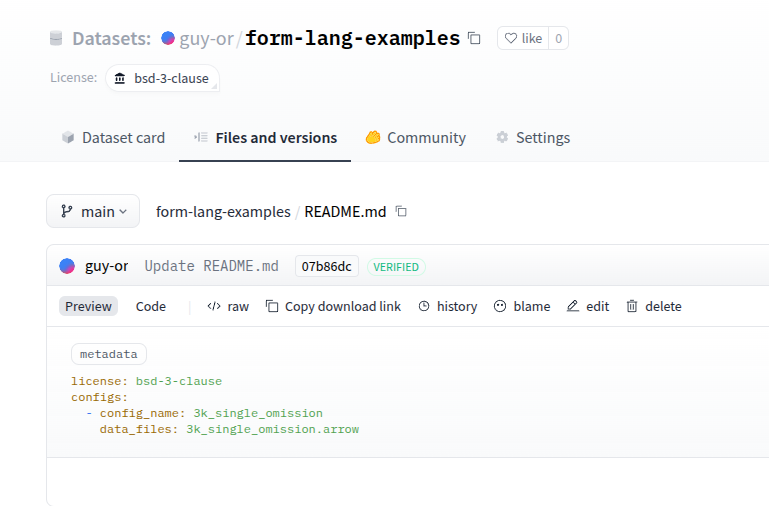

We now convert our `examples` DataFrame into a Dataset object.

In [59]:
ds = Dataset.from_pandas(examples)
ds.push_to_hub("guy-or/form-lang-examples", "3k_single_omission")
ds

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/114 [00:00<?, ?B/s]

Dataset({
    features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'originalFormAst', 'userPrompt'],
    num_rows: 3000
})

### Loading the Dataset from HuggingFace using `Datasets`

### Zero-shot evaluation using Llama 3.2-1B

The LLM might ignore the instruction to output plain code without the "```FormLang" delimiter, in that case we should try to extract the contents.

In [ ]:
def extract_code_block(text, lang):
  """
  Extracts a code block from a string.

  Args:
    text: The string containing the code block.
    lang: The name of the language the code block is written in.

  Returns:
    The code block, or None if no code block is found.
  """
  pattern = f"```{lang}\n(.*?)```"
  match = re.search(pattern, text, re.DOTALL)
  if match:
    return match.group(1).strip()
  return None

def extract_llm_formlang_output(text):
    # Strip leading and trailing whitespace and check for delimiters
    text = text.strip()
    return extract_code_block(text, "FormLang") or text

In [ ]:
llama3_pipeline = pipeline("text-generation", model="meta-llama/Llama-3.2-1B-Instruct", torch_dtype=torch.bfloat16, device_map="cpu")

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
%%time
pred_example_0 = llama3_pipeline([
    {"role": "system", "content": "You are a code generation AI assistant.\n" + get_system_prompt()},
    {"role": "user", "content": examples['userPrompt'][0]},
], max_new_tokens=10**4)
pred_example_0

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


CPU times: user 5min 50s, sys: 278 ms, total: 5min 51s
Wall time: 43.9 s


[{'generated_text': [{'role': 'system',
    'content': "You are a code generation AI assistant.\nYour job is to generate valid FormLang code according to the instructions given below:\nInspect the following FormLang Form definition, the start of the code will be denoted with ```FormLang and its end with ``` .\nAfter inspection, complete the Form's code according to the given a description of a new form element and a description of its location in the form.\nYou may assume that the new form element to be added is always either a 'form' or a 'field'.\nYour output must be valid and compiler-friendly FormLang code only.\nIf you are unsure of the FormLang syntax, try to infer it from the form code which is given below as an input.Your answer will be evaluated using an AST comparison of your code to the expected code.\nAssume that the input code is valid and requires no modification other than the NEW code you must generate.\nYou must output plain FormLang code without any additional text or

In [ ]:
pred_example_0_generated = pred_example_0[0]['generated_text'][2]['content']
print(extract_llm_formlang_output(pred_example_0_generated))

component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}


  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }

form i_ {
	comp userDetailsContainer 
	
  field M {
    state string
    comp counter style="(() => 91.82371540078952)()" as expression
  }
  field d {
    comp counter style="Math.sqrt(16)" as expression
  }
  field Bw {
    state boolean default "true" as expression
    comp otherTextBox 
  }
  field j {
    state boolean default "true" as expression
    comp otherTextBox 
  }
  
  field Ow {
    comp myCheckbox
    props {
      size
    }
  }
}

form g {
  comp OtherContainer2 
  

  field dw {
    comp myCheckbox size="#4a6461"
  }
}


In [ ]:
get_ast(extract_llm_formlang_output(pred_example_0_generated), True)

{'ast': '{"$type":"Form","name":"i_","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@0"},"componentPropsKeys":[],"componentPropsValues":[]},"children":[{"$type":"Field","name":"M","state":{"$type":"FieldStateDef","type":"string","isArray":false},"component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@7"},"componentPropsKeys":[{"$type":"ComponentPropKey","key":"style"}],"componentPropsValues":[{"$type":"ValueExpression","value":"(() => 91.82371540078952)()","isExpression":true}]}},{"$type":"Field","name":"d","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@7"},"componentPropsKeys":[{"$type":"ComponentPropKey","key":"style"}],"componentPropsValues":[{"$type":"ValueExpression","value":"Math.sqrt(16)","isExpression":true}]}},{"$type":"Field","name":"Bw","state":{"$type":"FieldStateDef","type":"boolean","defaultValue":{"$type":"ValueExpression","value":"true","isExpression":true},"isArray":false},"component":{"$ty